In [2]:
%matplotlib inline
from ggplot import *
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt

import sklearn.linear_model as sklin
import sklearn.metrics as skmet
import sklearn.cross_validation as skcv
import sklearn.grid_search as skgs
import sklearn.preprocessing as skpr
from sklearn.linear_model import Ridge
import pandas as pd
from sklearn.svm import SVR
from sklearn.linear_model.stochastic_gradient import SGDRegressor

/Users/Anuar_The_Great/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
train = np.loadtxt(open("/Users/Anuar_The_Great/Desktop/Project/1/train.csv", "rb"), 
                    delimiter=",", skiprows=1)
test0 = np.loadtxt(open("/Users/Anuar_The_Great/Desktop/Project/1/test.csv", "rb"), 
                    delimiter=",", skiprows=1)

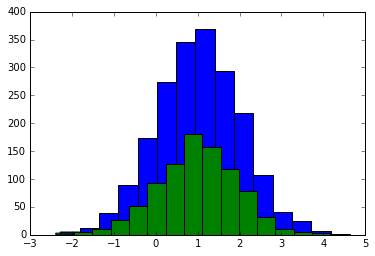

In [4]:
plt.hist(test0[:,6], bins=15)
plt.hist(train[:,6], bins=15)

# Getting rid of the outlier
train[207,:]
train = np.delete(train, 207, 0)

In [5]:
# Add squared terms
def get_features(data):
    return np.hstack((data, data*data)) 


X = train[:, 2:17]
test = test0[:, 1:16]
print("X.shape", X.shape)
print('test.shape', test.shape)

Y = train[:, 1]

# Adding Polynomial features to the data
poly = skpr.PolynomialFeatures(degree=3, interaction_only=False)
X = poly.fit_transform(X) 
poly = skpr.PolynomialFeatures(degree=3, interaction_only=False)
test = poly.fit_transform(test)

print("\nAfter Poly Transformation:")
print('X.shape', X.shape)
print('Y.shape', Y.shape)
print('test.shape', test.shape)

X.shape (899, 15)
test.shape (2000, 15)

After Poly Transformation:
X.shape (899, 816)
Y.shape (899,)
test.shape (2000, 816)


In [6]:
# Returns -Sqrt Mean Squared Error
def score(gtruth, pred):
    diff = gtruth - pred
    return -np.sqrt(np.mean(np.square(diff)))

scorefun = skmet.make_scorer(score)
neg_scorefun = skmet.make_scorer(lambda x, y: -score(x, y))

In [7]:
# First we will try solving Normal Equation
beta = np.linalg.solve(X.T.dot(X) + 20*np.eye(X.shape[1]), X.T.dot(Y))

print("Training Error: ", score(Y, beta.dot(X.T)))

X_train, X_test, y_train, y_test = skcv.train_test_split(
    X, Y, test_size=0.3, random_state=0)
beta = np.linalg.solve(X_train.T.dot(X_train) + 
                       125*np.eye(X_train.shape[1]), X_train.T.dot(y_train))
print("Test Error: ", score(y_test, X_test.dot(beta)))

Training Error:  -4.7068583317
Test Error:  -18.6073967708


In [39]:
# Now we will try SGD and Ridge Regression. In order to find optimal parameters
# we will use grid search.

param_grid = {'alpha': [1, 5, 10, 30, 50, 75, 100, 150, 200, 300, 750, 1000, 3000]}
param_grid = {'alpha': np.linspace(10, 200, 8),
             'l1_ratio': [ 0.3, 0.7],
             'power_t': [0.3, 0.6],
             'epsilon': [ 0.1, 1]}

sgd = SGDRegressor(average=False, eta0=0.01,
       fit_intercept=True, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='elasticnet',
       random_state=None, shuffle=True, verbose=1, warm_start=False)

In [40]:
%%capture
grid_search = skgs.GridSearchCV(sgd, param_grid, scoring=scorefun, cv=5)
grid_search.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='elasticnet', power_t=0.25,
       random_state=None, shuffle=True, verbose=1, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  10.     ,   37.14286,   64.28571,   91.42857,  118.57143,
        145.71429,  172.85714,  200.     ]), 'power_t': [0.3, 0.6], 'epsilon': [0.1, 1], 'l1_ratio': [0.3, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(score),
       verbose=0)

In [42]:
print(grid_search.best_estimator_)
print("\nBest Score: ", grid_search.best_score_)
#print(grid_search.grid_scores_)

SGDRegressor(alpha=10.0, average=False, epsilon=1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.7, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='elasticnet', power_t=0.6,
       random_state=None, shuffle=True, verbose=1, warm_start=False)

Best Score:  -47.56570384


In [11]:
# Iteration through the list of alphas and generation of accuracy from the testing set
alpha_list = [1, 5, 10, 30, 50, 75, 100, 150, 200, 300, 750, 1000, 3000]
scores_df = pd.DataFrame(alpha_list, columns=['alphas'])
scores_df['values'] = 1
for i, alpha_num in enumerate(alpha_list):
    lr = Ridge(alpha=alpha_num, tol=0.001, solver='auto')
    #lr.fit(X, Y)
    #Xtrain, Xtest, Ytrain, Ytest = skcv.train_test_split(X, Y, train_size=0.70)
    scores = skcv.cross_val_score(lr, X, Y, scoring=scorefun, cv=10)
    fn_score = np.mean(scores)
    print(fn_score)
    scores_df.iloc[i, 1] = fn_score

-41.619227188
-28.7511971242
-24.7789122776
-20.1844593461
-18.7773998286
-17.9989791188
-17.623501629
-17.3249628362
-17.2589906467
-17.3392319241
-18.0943077258
-18.4624071162
-20.3559479051


/Users/Anuar_The_Great/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


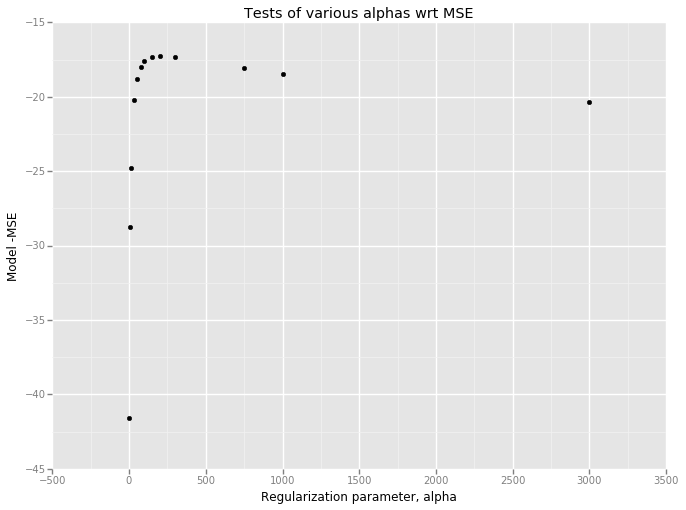

<ggplot: (293643245)>

In [12]:
ggplot(scores_df, aes(x='alphas', y='values')) + geom_point() +\
        labs('Regularization parameter, alpha', 'Model -MSE', 'Tests of various alphas wrt MSE')

In [13]:
def train_error(X, Y, alpha):
    lr_test = Ridge(alpha=alpha)
    lr_test.fit(X, Y)
    pred = lr_test.predict(X)
    submission = lr_test.predict(test)
    return score(Y, pred)

print("Train Error: ", train_error(X, Y, 50))
print("Train Error using Normal Equation: ", score(Y, beta.dot(X.T)))

scores = skcv.cross_val_score(Ridge(alpha=30), X, Y, scoring=scorefun, cv=5)
fn_score = np.mean(scores)
print("CV Error: ", fn_score)

Train Error:  -5.287543664
Train Error using Normal Equation:  -11.1332343165
CV Error:  -22.5231231642


In [18]:
# Trying SVM with different kernels
X = train[:, 2:17]
test = test0[:, 1:16]
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
#y_rbf = svr_rbf.fit(X, Y).predict(X)
y_lin = svr_lin.fit(X, Y).predict(X)
y_poly = svr_poly.fit(X, Y).predict(X)

# Training error
#print("RBF: ", score(Y, y_rbf))
print("Linear: ", score(Y, y_lin))
print("Polynomial: ", score(Y, y_poly))

Linear:  -36.2302542393
Polynomial:  -20.6614024926


In [21]:
# CV errors using SVMs
#scores = skcv.cross_val_score(svr_rbf, X, Y, scoring=scorefun, cv=20)
#print(np.mean(scores))
scores = skcv.cross_val_score(svr_lin, X, Y, scoring=scorefun, cv=5)
print(np.mean(scores))
scores = skcv.cross_val_score(svr_poly, X, Y, scoring=scorefun, cv=5)
print(np.mean(scores))

-36.6960175676
-25.4911749267


In [29]:
# Iteration through the list of alphas and generation of accuracy from the testing set
alpha_list = [ 0.01, 0.1, 0.5, 1, 5, 10, 30, 50, 75, 100, 135, 150, 200, 300, 1000]
scores_df = pd.DataFrame(alpha_list, columns=['alphas'])
scores_df['values'] = 1
for i, alpha_num in enumerate(alpha_list):
    sgd = SGDRegressor(alpha=alpha_num, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.25, learning_rate='invscaling',
       loss='squared_loss', n_iter=50, penalty='elasticnet', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

    #lr.fit(X, Y)
    #Xtrain, Xtest, Ytrain, Ytest = skcv.train_test_split(X, Y, train_size=0.70)
    scores = skcv.cross_val_score(sgd, X, Y, scoring=scorefun, cv=50)
    fn_score = np.mean(scores)
    print(fn_score)
    scores_df.iloc[i, 1] = fn_score
    

-35.72144445
-35.7822112182
-37.0380352545
-38.9961651702
-46.1476520527
-48.6841613562
-50.4100887114
-50.8303855652
-50.9349420922
-50.9505868771
-50.9499485534
-50.9477734535
-50.9511048375
-50.9390547068
-50.951967321


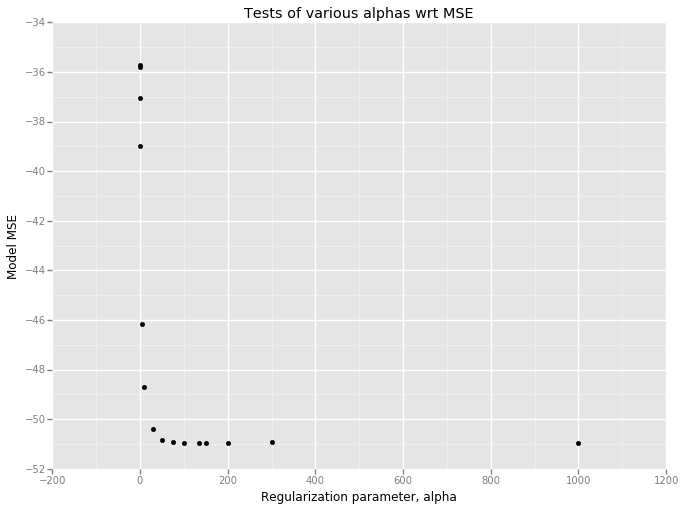

<ggplot: (300995885)>

In [30]:
ggplot(scores_df, aes(x='alphas', y='values')) + geom_point() +\
        labs('Regularization parameter, alpha', 'Model MSE', 'Tests of various alphas wrt MSE')

In [31]:
lr_test = Ridge(alpha=40)
lr_test.fit(X, Y)
submission = lr_test.predict(test)
np.savetxt('first.csv', submission)

In [34]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor()
param_grid = {'n_neighbors': [2, 3, 4, 6, 8],
             'leaf_size': [2, 5, 10, 30, 70],
             'algorithm': ['brute', 'kd_tree'],
             'weights': ['uniform', 'distance']}

In [35]:
grid_search = skgs.GridSearchCV(neigh, param_grid, scoring=neg_scorefun, cv=10)
grid_search.fit(X, Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [2, 3, 4, 6, 8], 'weights': ['uniform', 'distance'], 'leaf_size': [2, 5, 10, 30, 70], 'algorithm': ['brute', 'kd_tree']},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(<lambda>),
       verbose=0)

In [37]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)
#print(grid_search.grid_scores_)

KNeighborsRegressor(algorithm='brute', leaf_size=2, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')
40.7662766268
